In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(19)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [2]:
num_classes = 10
batch_size = 32

# Fashion MNIST dataset

data = torchvision.datasets.FashionMNIST
root = './data/FashionMNIST'
transform = transforms.ToTensor()

datasets = {x: data(root=root, train=x=='train', transform=transform) for x in ['train', 'val']}

dataloaders = {x: DataLoader(datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

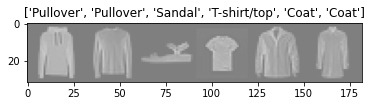

In [3]:
from utils.visual import imshow

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:6]
classes = classes[:6]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
plt.show()

In [4]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_length=None):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        if sequence_length is None:
            self.sequence_length = input_size
        else:
            self.sequence_length = sequence_length

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, self.sequence_length, self.input_size)

        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2

model = LSTMNet(input_size, hidden_size, num_layers, num_classes).to(device)

In [5]:
epochs = 3
learning_rate = 0.01

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.7)

model.train()
# Train the model
total_steps = len(dataloaders['train'])
for epoch in range(epochs):
    for i, (images, labels) in enumerate(dataloaders['train']):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, epochs, i+1, total_steps, loss.item()))
            print("Learning rate: {}\n".format(optimizer.param_groups[0]['lr']))
    lr_scheduler.step()

Epoch [1/3], Step [500/1875], Loss: 0.3696
Learning rate: 0.01

Epoch [1/3], Step [1000/1875], Loss: 0.5176
Learning rate: 0.01

Epoch [1/3], Step [1500/1875], Loss: 0.4781
Learning rate: 0.01

Epoch [2/3], Step [500/1875], Loss: 0.4264
Learning rate: 0.006999999999999999

Epoch [2/3], Step [1000/1875], Loss: 0.3076
Learning rate: 0.006999999999999999

Epoch [2/3], Step [1500/1875], Loss: 0.4987
Learning rate: 0.006999999999999999

Epoch [3/3], Step [500/1875], Loss: 0.3603
Learning rate: 0.004899999999999999

Epoch [3/3], Step [1000/1875], Loss: 0.2834
Learning rate: 0.004899999999999999

Epoch [3/3], Step [1500/1875], Loss: 0.6043
Learning rate: 0.004899999999999999



In [6]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['val']:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy: {} %'.format(100 * correct / total))


Test Accuracy: 87.76 %


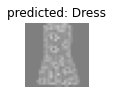

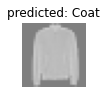

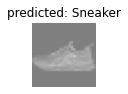

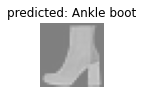

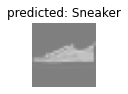

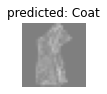

In [7]:
from utils.visual import visualize_model

visualize_model(model, device, dataloaders, class_names, num_images=6)
plt.show()

In [8]:
# Save the model checkpoint
torch.save(model.state_dict(), 'saved_models/lstm_fashionMNIST.pt')

### Resources

[A classic article on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[A classic article on LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)